In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from statsmodels.graphics.regressionplots import influence_plot
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from xgboost import XGBRegressor
%matplotlib inline


import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/kaggle/sale prediction/dataset/competitive-data-science-predict-future-sales'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/kaggle/sale prediction/dataset/competitive-data-science-predict-future-sales/items.csv
/content/drive/MyDrive/kaggle/sale prediction/dataset/competitive-data-science-predict-future-sales/sales_train.csv
/content/drive/MyDrive/kaggle/sale prediction/dataset/competitive-data-science-predict-future-sales/item_categories.csv
/content/drive/MyDrive/kaggle/sale prediction/dataset/competitive-data-science-predict-future-sales/sample_submission.csv
/content/drive/MyDrive/kaggle/sale prediction/dataset/competitive-data-science-predict-future-sales/test.csv
/content/drive/MyDrive/kaggle/sale prediction/dataset/competitive-data-science-predict-future-sales/shops.csv


In [5]:
df_sales = pd.read_csv('/content/drive/MyDrive/kaggle/sale prediction/dataset/competitive-data-science-predict-future-sales/sales_train.csv')
df_items = pd.read_csv('/content/drive/MyDrive/kaggle/sale prediction/dataset/competitive-data-science-predict-future-sales/items.csv')
df_shops = pd.read_csv('/content/drive/MyDrive/kaggle/sale prediction/dataset/competitive-data-science-predict-future-sales/shops.csv')
df_test = pd.read_csv('/content/drive/MyDrive/kaggle/sale prediction/dataset/competitive-data-science-predict-future-sales/test.csv')
df_sub = pd.read_csv('/content/drive/MyDrive/kaggle/sale prediction/dataset/competitive-data-science-predict-future-sales/sample_submission.csv')

def df_head(df) :
  return df.head()

df_head(df_sales)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
df_head(df_sub)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [7]:
df_head(df_items)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
df_head(df_shops)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


###Descriptive and exploratory data analysis

In [9]:
df_sales.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [10]:
df_items.groupby('item_category_id').count()

,item_name,item_id
item_category_id,,
0,4,4
1,2,2
2,75,75
3,34,34
4,15,15
...,...,...
79,1,1
80,6,6
81,7,7


In [12]:
df_items.groupby('item_category_id').mean()

<ipython-input-12-4ad0d08717a0>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_items.groupby('item_category_id').mean()


,item_id
item_category_id,
0,13552.250000
1,5673.000000
2,7434.800000
3,6113.705882
4,4969.066667
...,...
79,17717.000000
80,9249.000000
81,13351.857143


In [13]:
df_items['diff_col_of_item_id'] = df_items.groupby('item_category_id')['item_id'].max() - df_items.groupby('item_category_id')['item_id'].min()

df_items.head()

,item_name,item_id,item_category_id,diff_col_of_item_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,10816.0
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,134.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,7966.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,7419.0
4,***КОРОБКА (СТЕКЛО) D,4,40,11147.0


###Train and test dataset preparation and pre-processing

In [14]:
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [15]:
df_sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [18]:
#df_sales에서 중복된 행을 제거하는 작
df_sales.drop_duplicates(keep='first', inplace=True, ignore_index=True)

df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [19]:
#데이터프레임 'df_sales'에서 'item_price' 열의 값이 0보다 작은 행들을 선택하는 코드
df_sales[df_sales['item_price'] <0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,15.05.2013,4,32,2973,-1.0,1.0


In [20]:
df_sales.drop(df_sales[df_sales['item_cnt_day'] <0].index , inplace=True)
df_sales.drop(df_sales[df_sales['item_price']<0].index, inplace=True)

df_sales.shape

(2928486, 6)

###Outliers removal

In [25]:
#데이터프레임 'df_sales'의 'item_price'열에서 25번째 백분위 수를 계산하여 변수 'Q1'에 할당
Q1 = np.percentile(df_sales['item_price'], 25.0)
Q3 = np.percentile(df_sales['item_price'], 75.0)

# IQR: 사분위수 범위 계산
IQR = Q3 - Q1

df_sub1 = df_sales[df_sales['item_price'] > Q3 + 1.5*IQR]
df_sub2 = df_sales[df_sales['item_price'] < Q1 - 1.5*IQR]

# 이상치가 포함된 행들을 원본 데이터프레임에서 제거
df_sales.drop(df_sub1.index, inplace=True)

df_sales.shape

(2670931, 6)

In [26]:
df_sales['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [27]:
df_sales.groupby('date_block_num')['item_id'].mean()

date_block_num
0     10437.874241
1     10094.739024
2     10272.665975
3     10491.197571
4     10453.088679
5     10453.211951
6     10646.363618
7     10215.190504
8     10175.876895
9     10614.346861
10    10589.980521
11    10410.177452
12    10392.215130
13     9976.254429
14    10535.516754
15    10861.633872
16    10571.830409
17    10490.160861
18    10484.988244
19    10369.118885
20    10556.140961
21    10772.814302
22    10682.868015
23    10822.272561
24    10743.796818
25    10853.609323
26    11017.415613
27    11087.856680
28    10718.165604
29    10674.438441
30    11002.175358
31    10389.431964
32    10447.862064
33    11430.368451
Name: item_id, dtype: float64

In [30]:
price = round(np.array(df_sales.groupby('date_block_num')['item_price'].mean()).mean(),2)
print(price)

573.36


In [31]:
dict(round(df_sales.groupby('date_block_num')['item_price'].mean(),4))

{0: 523.3136,
 1: 530.6769,
 2: 515.1063,
 3: 507.681,
 4: 500.4043,
 5: 483.6083,
 6: 475.9361,
 7: 485.0816,
 8: 530.7074,
 9: 526.2786,
 10: 553.5716,
 11: 598.0684,
 12: 560.4089,
 13: 558.7864,
 14: 548.9686,
 15: 537.6172,
 16: 527.4048,
 17: 519.3315,
 18: 525.0034,
 19: 548.2421,
 20: 606.8177,
 21: 618.6799,
 22: 611.0263,
 23: 687.4857,
 24: 646.9772,
 25: 628.1663,
 26: 611.3147,
 27: 617.0509,
 28: 660.2883,
 29: 664.2991,
 30: 634.8502,
 31: 635.9069,
 32: 657.6738,
 33: 657.6354}

In [32]:
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0


In [33]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


###Feature engineering

create columns with mean price by date block in train and test dataset, remove item price from train

remove data_ block column from train data set

create new cloumns with mean price per shop id for both train and test dataset

merge df_items table with train and test dataset on item id and create new column item category

In [34]:
#df_sales.drop('mean_price_data_block',inplace=True, axis=1)

replace_dict = dict(round(df_sales.groupby('date_block_num')['item_price'].mean(),2))

In [36]:
df_sales['date_block_num'] = df_sales['date_block_num'].replace(replace_dict)

df_train = df_sales.copy()
df_train.drop(['date','item_price'], axis=1, inplace=True)
df_train.rename(columns = {'date_block_num':'mean_price_by_column'}, inplace=True)
df_train.head()

,mean_price_by_column,shop_id,item_id,item_cnt_day
0,523.31,59,22154,1.0
1,523.31,25,2552,1.0
3,523.31,25,2554,1.0
4,523.31,25,2555,1.0
5,523.31,25,2564,1.0


In [38]:
mean_price = np.array(df_sales.groupby('date_block_num')['item_price'].mean()).mean()
mean_price

573.3638104404596

In [39]:
df_test.shape

(214200, 3)

In [40]:
df_train.shape

(2670931, 4)

In [41]:
#df_test.drop('ID',inplace=True, axis=1)
df_test.head()
com_df = pd.concat([df_train, df_test])

com_df['mean_price_by_column'] = com_df['mean_price_by_column'].fillna(value=price)
com_df['item_cnt_day'] = com_df['item_cnt_day'].fillna(value=0)

test_df = com_df[com_df['item_cnt_day'] == 0]
train_df = com_df[com_df['item_cnt_day'] != 0]

In [42]:
test_df.shape

(214200, 5)

In [43]:
testdf = test_df.copy()

testdf.drop('ID', inplace=True, axis=1)
testdf.drop('item_cnt_day', inplace=True, axis=1)
testdf

,mean_price_by_column,shop_id,item_id
0,573.36,5,5037
1,573.36,5,5320
2,573.36,5,5233
3,573.36,5,5232
4,573.36,5,5268
...,...,...,...
214195,573.36,45,18454
214196,573.36,45,16188
214197,573.36,45,15757
214198,573.36,45,19648


In [44]:
traindf = train_df.copy()

traindf.drop('ID', inplace=True, axis=1)

In [45]:
traindf.head()

,mean_price_by_column,shop_id,item_id,item_cnt_day
0,523.31,59,22154,1.0
1,523.31,25,2552,1.0
3,523.31,25,2554,1.0
4,523.31,25,2555,1.0
5,523.31,25,2564,1.0


###Train data and test data for modeling and evalution

In [47]:
#test_df.drop('item_cnt_day', inplace=True, axis=1)
#'testdf'데이터프레임의 'item_id'열에 대해 표준화(standardization)을 수행합니다.
#표준화는 데이터의 평균을 0으로, 표준편차를 1로 만드는 과정입니다.
testdf['item_id'] = (testdf['item_id'] - testdf['item_id'].mean())/testdf['item_id'].std()
testdf.head()

,mean_price_by_column,shop_id,item_id
0,573.36,5,-0.956779
1,573.36,5,-0.911518
2,573.36,5,-0.925432
3,573.36,5,-0.925592
4,573.36,5,-0.919835


In [49]:
traindf['item_id'] = (traindf['item_id'] - traindf['item_id'].mean())/traindf['item_id'].std()
traindf.head()

,mean_price_by_column,shop_id,item_id,item_cnt_day
0,523.31,59,1.830655,1.0
1,523.31,25,-1.258324,1.0
3,523.31,25,-1.258009,1.0
4,523.31,25,-1.257852,1.0
5,523.31,25,-1.256433,1.0


###Model1

In [50]:
X = traindf.loc[:,['mean_price_by_column','shop_id','item_id']]
y = traindf.loc[:,'item_cnt_day']

In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state = 42)

model1 = LinearRegression()

model1.fit(X_train, y_train)

print("regression coefficients are:", model1.coef_)

y_pred = model1.predict(X_valid)

MSE = mean_squared_error(y_valid,y_pred)
MAE = mean_absolute_error(y_valid,y_pred)
R2 = r2_score(y_valid, y_pred)

print("MSE : ", MSE)
print("MAE : ", MAE)
print("R2 : ", R2)

regression coefficients are: [ 0.00052884 -0.00073067  0.06059091]
MSE :  3.568506908593113
MAE :  0.4151444070506008
R2 :  0.001130854051605401


###Model2

In [52]:
X_new = X.copy()
X_new = sm.add_constant(X_new)
test_df_new = test_df.copy()
test_df_new = sm.add_constant(test_df_new)
X_train_new, X_valid_new, y_train_new, y_valid_new = train_test_split(X_new, y, train_size=0.8, random_state=42)

In [54]:
#using statsmodel api
stats_model = sm.OLS(y_train_new, X_train_new)
stat_fit = stats_model.fit()
print("Model coeffieciants:", stat_fit.params)
print("\nModel summary: ", stat_fit.summary2())

Model coeffieciants: const                   0.956325
mean_price_by_column    0.000529
shop_id                -0.000731
item_id                 0.060591
dtype: float64

Model summary:                     Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.001        
Dependent Variable: item_cnt_day     AIC:                10379178.5089
Date:               2024-03-01 13:16 BIC:                10379228.8081
No. Observations:   2136744          Log-Likelihood:     -5.1896e+06  
Df Model:           3                F-statistic:        458.9        
Df Residuals:       2136740          Prob (F-statistic): 4.14e-298    
R-squared:          0.001            Scale:              7.5353       
----------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                   0.9563   0.0183 52.3667 0.0000

###Residual analysis

<Figure size 800x800 with 0 Axes>

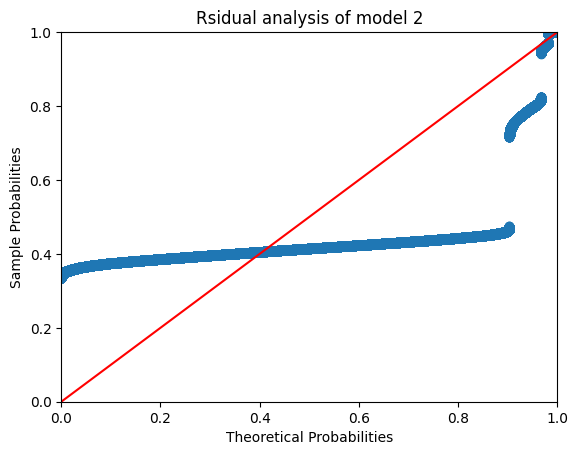

In [55]:
model_residual = stat_fit.resid
probplot = sm.ProbPlot(model_residual)
plt.figure(figsize=(8,8))
probplot.ppplot(line = '45')
plt.title("Rsidual analysis of model 2")
plt.show()

###Test of Homoscedasticity

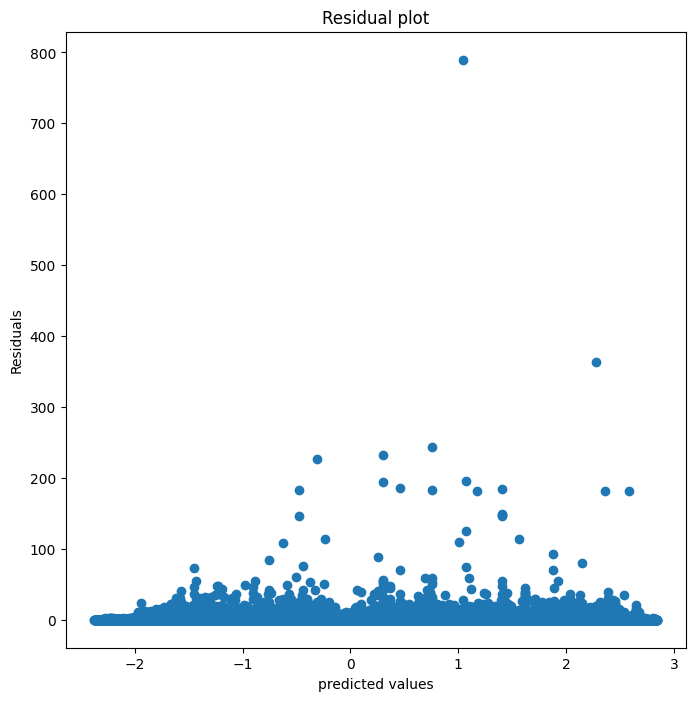

In [56]:
def get_std_val(vals):
    return (vals - vals.mean())/vals.std()

plt.figure(figsize=(8,8))
plt.scatter(get_std_val(stat_fit.fittedvalues), get_std_val(model_residual))
plt.title("Residual plot")
plt.xlabel("predicted values")
plt.ylabel("Residuals")
plt.show()

###Outlier analysis

In [57]:
traindf['z_score_item'] = zscore(traindf['item_cnt_day'])

In [58]:
#outliears in y variable
traindf[(traindf['z_score_item'] > 3.0) | (traindf['z_score_item'] < -3.0)]

,mean_price_by_column,shop_id,item_id,item_cnt_day,z_score_item
404,523.31,25,-1.192139,13.0,4.531269
4173,523.31,25,0.642150,10.0,3.376277
4230,523.31,25,0.443908,10.0,3.376277
5410,523.31,25,0.931791,11.0,3.761274
5415,523.31,25,0.931791,10.0,3.376277
...,...,...,...,...,...
2935356,657.64,25,-0.052957,79.0,29.941082
2935357,657.64,25,-0.052957,26.0,9.536232
2935358,657.64,25,-0.052957,17.0,6.071257
2935371,657.64,25,-0.052800,34.0,12.616209
